Sta 663 - Statistical Computing and Computation - Midterm 1
-----------
Due Monday, February 28th by 5:00 pm.

## Setup

In [1]:
# Load necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import optimize
from scipy.spatial.distance import cdist,squareform
import matplotlib.pyplot as plt

In [2]:
# Load data
d1 = pd.read_csv("data/d1.csv")
d2 = pd.read_csv("data/d2.csv")
d3 = pd.read_csv("data/d3.csv")

<AxesSubplot:xlabel='x', ylabel='y'>

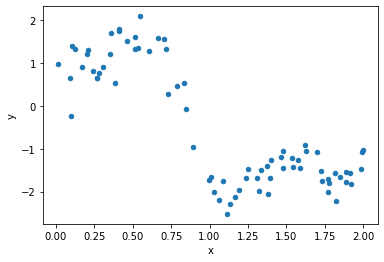

In [3]:
d1.plot.scatter(x = 'x', y = 'y')

<AxesSubplot:xlabel='x', ylabel='y'>

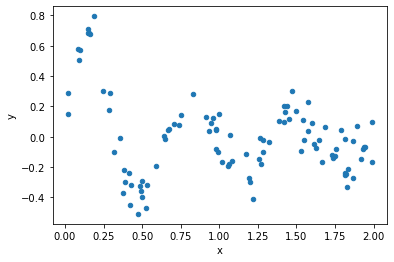

In [4]:
d2.plot.scatter(x = 'x', y = 'y')

<AxesSubplot:xlabel='x', ylabel='y'>

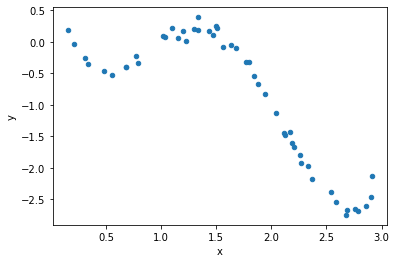

In [5]:
d3.plot.scatter(x = 'x', y = 'y')

In [6]:
# Helper functions

## function for calculating distance
def sqdis(x1,x2):
    """
    A function that calculates squared distance between x1 and x2 (scalars)
    
    input: 
        x1: first input of data in array-like form 
        (each element correspond to one data point in this given data set)
        x2: second input of data in array-like form
    output: 
        squared distance matrix
    """
    # convert the dim of input to meet the requirement of cdist function
    x1 = np.expand_dims(x1, axis=1)
    x2 = np.expand_dims(x2, axis=1)
    
    # calculate distance matrix
    distance = cdist(x1,x2,metric='euclidean')
    sq_distance = np.square(distance) # squared elements
    
    return sq_distance

## function for calculating covariance
def cov(x1,x2,l,sigma_s_2,sigma_n_2 = 0.1):
    """
    A function that calculate the covariance matrix of the data set
    
    input:
        x1: first input of data in array-like form 
        (each element correspond to one data point in this given data set)
        x2: second input of data in array-like form
        sigma_n_2: irreducible measurement error, here we treat it as fixed with a value of 0.1 
        sigma_s_2: scale variance parameter and determines the average distance away from the mean 
                    that can be taken by the function
        l: length-scale parameter which determines the range of the “spatial” dependence between points
    output:
        covariance matrix
    """
    # initialize
    m = len(x1)
    n = len(x2) 
    I = np.eye(m,n)
    
    # calculate covariance matrix
    covariance = I * sigma_n_2 + sigma_s_2 * np.exp(sqdis(x1,x2)/(-2*l))
    
    return covariance

## function for calculating negative log-likelihood 
def loglike(d, l, sigma_s_2, sigma_n_2 = 0.1):
    """
    A function that output the negative log-likelihood function for ooptimization
    Since we are optimizing over sigma_n_2(fixed here), sigma_s_2 and l, we can only consider terms that contains 
    covariance matrix
    Here mu = 0
    
    input:
        d: the data set we are optimizing over
        sigma_n_2: irreducible measurement error, here we treat it as fixed with a value of 0.1 
        sigma_s_2: scale variance parameter and determines the average distance away from the mean 
                    that can be taken by the function
        l: length-scale parameter which determines the range of the “spatial” dependence between points
    output:
        part of the negative log-likelihood function that contains the parameter we want
    """
    # initialize 
    n = d.shape[0]
    x = d.loc[:,"x"]
    y = d.loc[:,"y"]
    
    # calculate covariance matrix for this given data set
    Sigma = cov(x,x,l,sigma_s_2,sigma_n_2 = 0.1)
    
    return np.log(np.linalg.det(Sigma)) + y.T @ np.linalg.inv(Sigma) @ y
    

## Task 1 - Model fitting

The basic idea of task 1 is as follows. First thing is to draw some random values between the lower bound and upper bound for the initial values of optimizaiton parameters. Then for each pair of ($\sigma_s^2$, l), we do an optimizaiton on the data set using "optimize.minimize()". For each pair of initial values, we would obtain its optimized parameters. After that we find the pair that has the smallest negative log-likelihood function value.

First of all, we need to draw some values of $\sigma_s^2$ and l as the ramdom starting point for the optimization process. We can do this by simply using a uniform distribution random generator within our given lower bound and upper bound. By combining these initial values and our data set, we have all the things we need to start the optimization process. 

To iterate over all the initial values, I used the map function to apply the negative log-likelihood funtion to each pair of initial parameters values. Here I used 'L-BFGS-B' method since it does not require the gradient. Also, the "bounds" parameter with a "Bounds" object input is used here to make sure the parameters are within our given range.

After going through the minimize funtion and filtering out failed results, we obtained a list of successfully optimized results. By applying the negetive log-likelihood function to each of them, we can easily obtain our best MLE values for the 3 parameters.

In [7]:
def fit(d, n_init,lb = [1e-6,1e-6], ub = [5,2], seed =663):
    """
    A function which returns the MLEs of sigma_n_2(fixed in this case), sigma_s_2 and l using L-BFGS-B
    
    input:
        d: the data set we are optimizing over
        n_init: number of initial guesses to use (i.e. number of optimizations to run)
        lb: list (or array) of parameter lower bounds 
        ub: list (or array) of parameter upper bounds for [sigma_s_2,l]
        seed: a seed value which will be used to initialize numpy.random.default_rng()
    output:
        theta: a list of optimized paramters including sigma_n_2(fixed in this case), sigma_s_2 and l
    """
    # initialize
    bounds = optimize.Bounds(lb,ub)
    rng = np.random.default_rng(seed=seed)
    theta0 = rng.uniform(lb,ub,(n_init,2))    # theta0 = [sigma_s_2,l]
    # negative log-likelihood function that takes in different parameter values
    func = lambda para: loglike(d = d, sigma_s_2 = para[0], l = para[1])
    
    try:
        # find the minimum points of all initial value pairs
        result = list(map(lambda theta:optimize.minimize(func,theta, method='L-BFGS-B',
                                                    bounds = bounds),theta0))
        # find success results
        MLE_theta = [res.x for res in result if res.success == True]
        if len(MLE_theta)>0:
            # find the best parameter of all optimized results
            opt_theta = MLE_theta[np.argmin(list(map(func,MLE_theta)))]
            return [0.1] + list(opt_theta)
        else:
            # raise error if no success output
            raise RuntimeError("Optimization attempts fail")
    except RuntimeError as e:
        print("Error：",repr(e))

In [8]:
theta1 = fit(d1,50,seed = 66301); print(theta1) 
theta2 = fit(d2,50,seed = 66302); print(theta2) 
theta3 = fit(d3,50,seed = 66303); print(theta3) 

[0.1, 1.8260302302350389, 0.08997235917846551]
[0.1, 0.0620761062471531, 0.02229613235698743]
[0.1, 2.0360812944089335, 0.5986501032707098]


## Task 2 - Prediction

In this task, I am using the optimized parameters we obtained from `fit()` function to predict y values ($y_p$) for new points $x_p$.

We have already know that $y_p$ follows a multivariate normal distribution. To draw samples of $y_p$, first we need to approximate the parameters of MVN distribution. I got the range of x in this particular data set then used `np.linspace()` to generate 500 $x_p$ in equally space grid.

Then I followed the formula to compute the mean and variance parameter for MVN, and drew `n_draws` samples of $y_p$ with same length as $x_p$.

Finally I converted the arrays to dataframes and concatenated them together. Here I used list comprehension for renaming the columns with reasonable names.

In [9]:
def predict(d,n_draws, theta, seed, x_p = None):
    """
    A function which returns the prediction values of y on prediction points x_p
    
    input:
        d: the data set that was fit (and predict on)
        d_draws: number of draws to make from the conditional distribution
        theta: the MLEs of sigma_n_2,sigma_s_2 and l (which can be obtained using fit())
        seed: seed value that is used to initialize numpy.random.default_rng() for this function.
        x_p: array of x prediction locations, default to be None.
             if no input value, it will be computed based on the input data set
    output:
        result: a dataframe in wide format which contains x_p and d_draws of y_p
    """
    # initial values
    rng = np.random.default_rng(seed=seed)
    sigma_n_2 = theta[0]
    sigma_s_2 = theta[1]
    l = theta[2]
    x = d.loc[:,"x"]
    y = d.loc[:,"y"]
    
    # if no specific x_p input, then we need to generate x_p inside predict base on data set
    if x_p == None:
        # obtain the range of generating x_p
        ub = np.array([max(d["x"])])
        lb = np.array([min(d["x"])])
        # generate equally space grid of x_p
        x_p = np.linspace(lb,ub,500).flatten()
    
    # varibles for formula simplification
    Sigma_xpx = cov(x_p,x,l,sigma_s_2,sigma_n_2)
    Sigma_x = cov(x,x,l,sigma_s_2,sigma_n_2)
    Sigma_p = cov(x_p,x_p,l,sigma_s_2,sigma_n_2)
    
    # calculate MVN parameters
    mu_star = Sigma_xpx @ np.linalg.inv(Sigma_x) @ y
    Sigma_star = Sigma_p - Sigma_xpx @ np.linalg.inv(Sigma_x) @ Sigma_xpx.T
    
    # draw samples from MVN
    y_p = rng.multivariate_normal(mu_star,Sigma_star,size = (n_draws)).transpose()
    
    # convert to df
    x_p = pd.DataFrame(x_p)
    y_p = pd.DataFrame(y_p)
    # name columns
    x_p.columns = ["x_p"]
    y_p.columns = ["Sample" + str(i) for i in range(1,n_draws+1)]
    # join df
    result = pd.concat([x_p,y_p],axis = 1)
    
    return result

In [10]:
pred1 = predict(d1,50,theta = theta1, seed = 66301) # Add arguments as needed
pred2 = predict(d2,50,theta = theta2, seed = 66302) # Add arguments as needed
pred3 = predict(d3,50,theta = theta3, seed = 66303) # Add arguments as needed

## Task 3 - Plotting

In this task, we are drawing the mean of predicted y_ps and its 95% CI(empirically determined from the prediction samples)

First, we need to calculte the mean values and their corresponding CI. By simply using the `df.mean(axis=1)` I got the mean values. To empirically determine the 95% CI, I used the `np.percentile()` function for the 2.5% and 97.5% percentiles. 

Then I draw the mean values using `sns.lineplot()` and the CI using `plt.fill_between()`. To enlarge the plot while maintaining the length-width ratio as best as I can, I set figsize to be (10,5).

Finally I added a scatter plot on this plot to show the original data set `d` if d is inputed.

From the plot we see that most of the original points fall inside the blue CI area, suggesting that the whole precess is doing a satisfactory job.

In [11]:
def plot_gp(pred, d = None):
    """
    A function which draw the line of predicted values, CI of predicted values 
    and original data points(if data set is imported)
    
    input:
        pred: predicted values (which is simulated by predict() function)
        d: the original data set
    output:
        a composite plot
    """
    # obtain size of draws for computation of mean and CI
    cols = pred.shape[1]
    
    # obtain x values, means of ys and bounds of CIs
    xp = pred.iloc[:,0]
    yp = pred.iloc[:,1:cols].mean(axis = 1)
    y1 = np.percentile(pred.iloc[:,1:cols],2.5,axis = 1)
    y2 = np.percentile(pred.iloc[:,1:cols],97.5,axis = 1)
    
    # draw the line of mean
    plt.figure(figsize = (10,5), layout = "constrained")
    ax = sns.lineplot(x = xp, y = yp, label = 'mean of y_p')
    
    # fill the CI
    plt.fill_between(
        x = xp,
        y1 = y1,
        y2 = y2,
        alpha = 0.3,
        label = "95% CI"
    )
    
    # plot the original data points
    # if d is inputed, the default "None" will be overwritten
    plt.scatter(x = d["x"], y = d["y"],label = 'original data set')
    
    # add legend and axis label
    plt.legend(loc = 'upper right')
    plt.xlabel('x values')
    plt.ylabel('y values')
    
    plt.show()
    pass

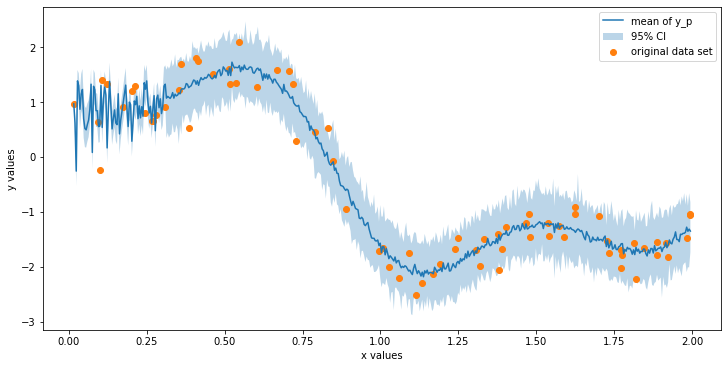

In [12]:
plot_gp(pred1, d1)

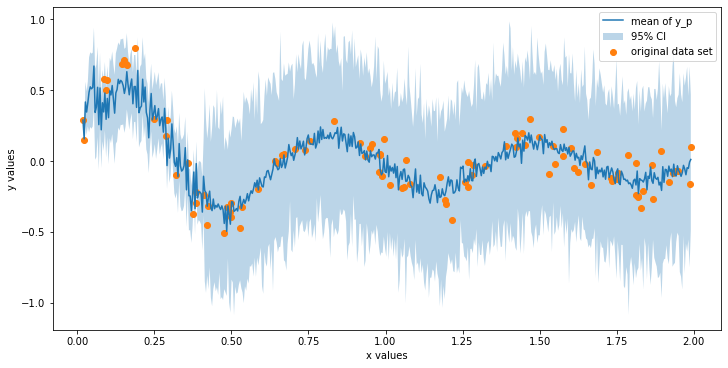

In [13]:
plot_gp(pred2, d2)

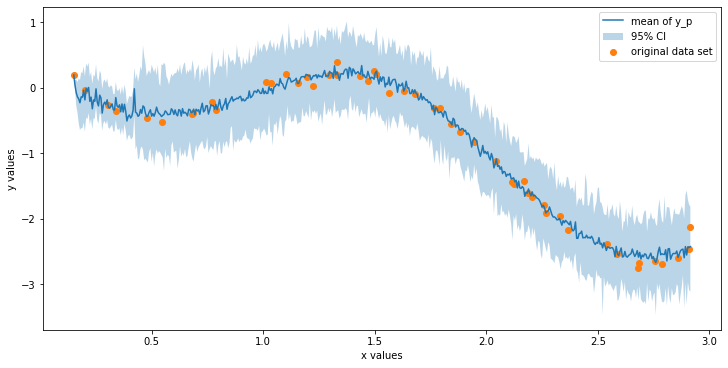

In [14]:
plot_gp(pred3, d3)